<a href="https://colab.research.google.com/github/lourencocavalcante/Neurocomputacao/blob/main/CAP351_Projeto_01_MLP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[<img src="https://github.com/lourencocavalcante/LogosINPE/blob/main/logoinpe.png?raw=true" width = 500 align="left">](https://www.gov.br/inpe/pt-br)

[<img src="https://github.com/lourencocavalcante/LogosINPE/blob/main/LogoCAP.png?raw=true" width = 300 align="right">](http://www.inpe.br/posgraduacao/cap/)

# **CAP-351 Neurocomputação**

**Professor:**
*Dr. Marcos Goncalves Quiles*

**Aluno:**
*Lourenço José Cavalcante Neto*

---

**PROPOSTA DE PROJETO 1: Experimentos com a rede Multi-layer Perceptron (MLP)**

**Descrição do projeto:**

1. Selecionar dois datasets (não triviais): Um dataset para classificação; Um dataset para regressão; Separar em treino/validação/teste.

2. Treinar modelos MLP para os dois problemas (**classificação** e **regressão**)

3. Considerar:
  * Diferentes topologias (>=5 topologias, variar número de
camadas)
  * Usar o algoritmo original SGD (não usar algoritmos otimizados,
e.g. ADAM)
  * Avaliar o impacto do uso do Momentum
  * Avaliar o impacto do uso da regularização (i.e. L2)

4. Ilustrar graficamente a evolução do treinamento (treino/validação).

5. Confeccionar um relatório (reprodutível) contendo os
experimentos e resados

O presente material pode ser acessado no **github**: 

# **Bibliotecas/Pacotes**

In [157]:
import pandas as pd

import numpy as np
import seaborn as sns

import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import math

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.layers import Dropout
from tensorflow.keras.regularizers import l2

from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier

import datetime

from google.colab import drive
drive.mount('/content/drive')

print(tf.__version__)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
2.8.2


# **Dataset**
 
Os Dados são de um equipamento chamado **Disdrômetro RD80** (também chamado de **Joss**). Instalado próximo à torre **ATTO**, em um sítio chamado Campina, na região amazônica, o Disdrômetro RD80 mede a distribuição das gotas de chuva que chegam à superfície. No total, o Dataset possui 06 atributos, os são listados abaixo:

```
Datetime
Rain Intensity (mm/h)
radar reflectivity (1/mm6m3)
Liquid watercontent (g/m3)
Mean weight diameter(mm)
Time integration (s)
```

*Ob.: Conforme sugerido/autorizado pelo professor Marcos na aula do dia 11/07, o mesmo Dataset será utilizado para os problemas de Classificação e Regressão.*

## **Importação, Formatação, Tratamento e Visualização dos dados**

In [220]:
#Importando o Dataset e criando o Dataframe
df_rd80_full = pd.read_csv("/content/drive/MyDrive/MestradoCAP/Lourenco/cap351/Datasets/df_final_rd80_joss.csv")
df_rd80_full = pd.DataFrame(df_rd80_full)

#Aqui verificamos o tamanho e quantidade de atributos do Dataset
print('Tamanho do dataset: ',df_rd80_full.shape[0], ', quantidade de atributos: ', df_rd80_full.shape[1])

Tamanho do dataset:  315420 , quantidade de atributos:  6


Como podemos ver, o tamanho do nosso Dataset é de 315.420 e isso pode ocasionar um custo computacional muito alto durante os experimentos e testes do Projeto. Sendo assim, será utilizado apenas 1/3 dos dados.

In [221]:
#Definindo uma parte do Dataset para usá-lo neste Projeto
limit_date = datetime.datetime(year=2022, month=1,day=1)

df_rd80_full = df_rd80_full.set_index('Datetime')

df_rd80 = df_rd80_full.loc[df_rd80_full.index >= str(limit_date)]
df_rd80 = df_rd80.loc[df_rd80['Rain Intensity (mm/h)'] > 0]
df_rd80.reset_index(inplace=True)

print('Tamanho do Dataset que será utilizado: ', df_rd80.shape[0])


Tamanho do Dataset que será utilizado:  17913


In [222]:
#Carregando o Dataset
df_rd80.loc[df_rd80['Rain Intensity (mm/h)'] > 0].head()

,Datetime,Rain Intensity (mm/h),radar reflectivity (1/mm6m3),Liquid watercontent (g/m3),Mean weight diameter(mm),Time integration (s)
0,2022-01-07 18:17:00,0.11612,18.61334,0.00773,1.05851,60.0
1,2022-01-07 18:19:00,0.87373,376.07019,0.04355,1.59702,60.0
2,2022-01-07 18:20:00,0.47670,203.73297,0.02424,1.56469,60.0
3,2022-01-07 18:21:00,2.39053,952.55902,0.12105,1.55338,60.0
4,2022-01-07 18:22:00,1.58020,582.23944,0.08347,1.47401,60.0


In [223]:
#Normalizando os dados
#É necessário assumir que os valores para Rain Intensity (mm/h) que forem menores que 0.1 sejam considerados como 0(zero)
df_rd80['Rain Intensity (mm/h)'].loc[df_rd80['Rain Intensity (mm/h)'] < 0.1] = 0

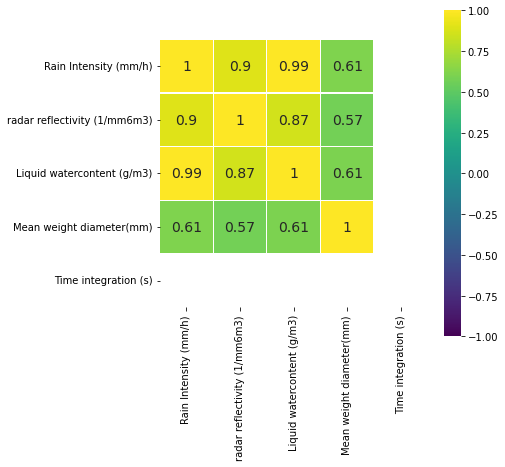

In [224]:
#Visualizando as correlações entre as variáveis
corr = df_rd80.corr()
plt.figure(figsize=(6, 6))
sns.heatmap(corr[(corr >= 0.30) | (corr <= -0.30)],cmap='viridis', vmax=1.0, vmin=-1.0, linewidths=0.1, annot=True, annot_kws={"size": 14}, square=True);

[]

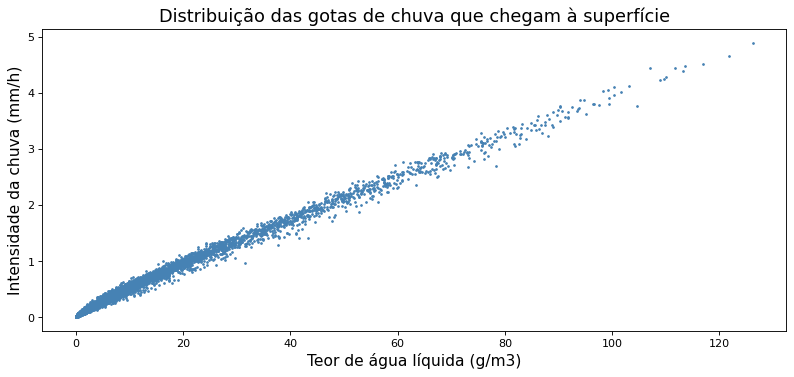

In [252]:
figure(figsize=(12,5),dpi=80)
plt.scatter(df_rd80['Rain Intensity (mm/h)'] ,df_rd80['Liquid watercontent (g/m3)'],s=2, color='#4682B4')
plt.xlabel(r'Teor de água líquida (g/m3)',size=14)
plt.ylabel(r'Intensidade da chuva (mm/h)',size=14)
plt.title("Distribuição das gotas de chuva que chegam à superfície", size=16)
plt.plot()

Conforme orientações para o projeto, para realizar o treinamento e validação do aprendizado de uma rede **Multi-layer Perceptron (MLP)**, realizou-se a divisão do conjunto de dados em dois grupos: Treino (70%) e Teste (30%). A biblioteca scikit-learn nos auxiliará nesta tarefa. 

In [229]:
#Dividindo os datasets de treino e teste
x_train, x_test, y_train, y_test = train_test_split(df_rd80['Rain Intensity (mm/h)'] ,df_rd80['Liquid watercontent (g/m3)'], test_size=0.76)
print('Tamanho do dataset para treinamento: ',len(x_train))
print('Tamanho do dataset para validação: ',len(x_test))

Tamanho do dataset para treinamento:  4299
Tamanho do dataset para validação:  13614


Após dividir o Dataset, inicialmente vamos checar o comportamento do dataset de Treino e de Teste da rede, para entender o que a rede buscará aprender e o que esta rede buscará prever.

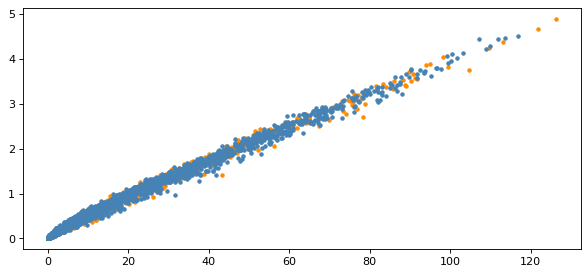

In [251]:
figure(figsize=(9,4),dpi=80)
plt.plot(x_train, y_train, '.', color='#FF8C00', label="Dados para Treinamento")
plt.plot(x_test, y_test, '.', color='#4682B4', label="Dados para Teste")
plt.show()

# **PROBLEMA 1: Regressão**
Com o objetivo de construir uma rede capaz de encontrar uma lei de regressão para o problema, serão criadas 05(cinco) topologias de rede MLP diferentes. O primeiro caso será um simples e clássico de um perceptron e a partir do segundo será modificado o número de camadas e o número de neurônios.

**Valores para configurações dos Hiperparâmetros do Momentum e Regularização (L2) para avaliar seus impactos**

In [236]:
#Configurações para avaliar o impacto do uso do Momentum e da Regularização (L2)
momentum =    [0.1, 0.2, 0.3, 0.0]
regularizer = [0.3, 0.2, 0.1, 0.0]
dropout = [0.0, 0.0, 0.0, 0.0]

#Define a quantidade de épocas para o treinamento
epochs = 1000 

## **Topologia I**
Este primeiro será um caso simples e clássico de um perceptron. A rede neural que será criada  é uma MLP com 2 camadas, sendo estas a camada de entrada e a camada de saída. 




**Criação dos modelos**

In [237]:
#Modelos da Topologia I
modelos_tpl_I = []

for res in range(0,4):
  #print(i)
  sgd = tf.keras.optimizers.SGD(learning_rate=0.01, momentum=momentum[res])
  modelos_tpl_I.append(keras.Sequential())
  modelos_tpl_I[res].add(keras.layers.Dense(units=3, kernel_regularizer=l2(regularizer[res]), input_shape=[1], activation="tanh"))
  modelos_tpl_I[res].add(keras.layers.Dense(units=1, activation="linear"))
  #tf.keras.utils.plot_model(modelos_tpl_I[res], show_shapes=True)
  modelos_tpl_I[res].compile(loss='mean_squared_error', optimizer=sgd, metrics=["mean_absolute_error"])

**Agora vamos treinar os Modelos criados**

In [ ]:
early = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=100)

history_modelos_tpl_I = []
for res in range(0,4):
  history_modelos_tpl_I.append(modelos_tpl_I[res].fit(x_train, y_train, epochs=epochs, batch_size=10, validation_split=0.2, verbose=True)) #callbacks=[early]


**Resultados do Treinamento**

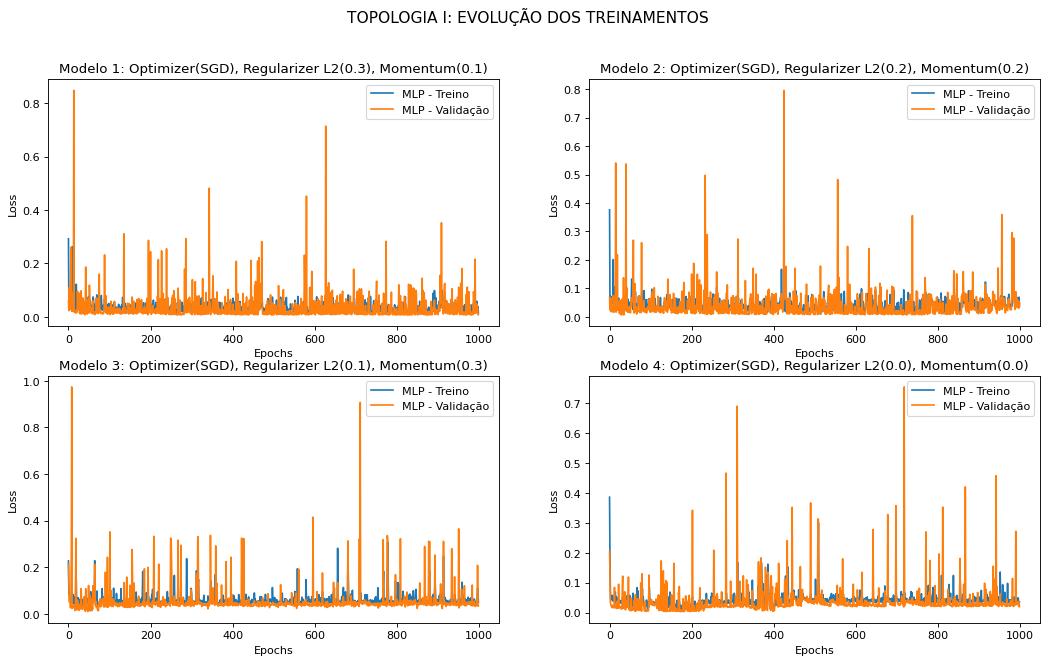

In [246]:
figure(figsize=(16,9),dpi=80)
plt.suptitle('TOPOLOGIA I: EVOLUÇÃO DOS TREINAMENTOS', size=14)
for res in range(0,4):
    plt.subplot(2,2,res+1)
    plt.title('Modelo '+ str(res+1) + ': Optimizer(SGD), Regularizer L2('+str(regularizer[res])+'), Momentum('+str(momentum[res])+')')
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.plot(history_modelos_tpl_I[res].history['loss'], label="MLP - Treino")
    plt.plot(history_modelos_tpl_I[res].history['val_loss'], label="MLP - Validação")
    plt.legend()
plt.show()

**Avaliação**

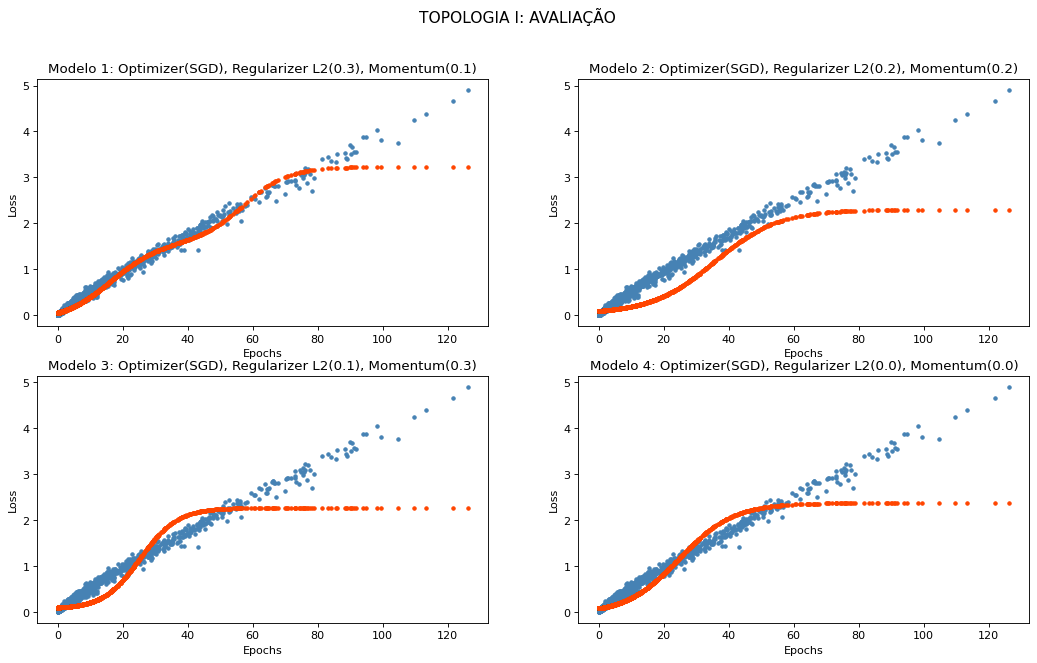

In [247]:
figure(figsize=(16,9),dpi=80)
plt.suptitle('TOPOLOGIA I: AVALIAÇÃO', size=14)

for res in range(0,4):

  plt.subplot(2,2,res+1)
  y_rest = modelos_tpl_I[res].predict(x_train)
  plt.plot(x_train, y_train, '.', color='#4682B4')
  plt.plot(x_train, y_rest, '.',color='#FF4500')
  plt.title('Modelo '+ str(res+1) + ': Optimizer(SGD), Regularizer L2('+str(regularizer[res])+'), Momentum('+str(momentum[res])+')')
  plt.xlabel("Epochs")
  plt.ylabel("Loss")

plt.show()

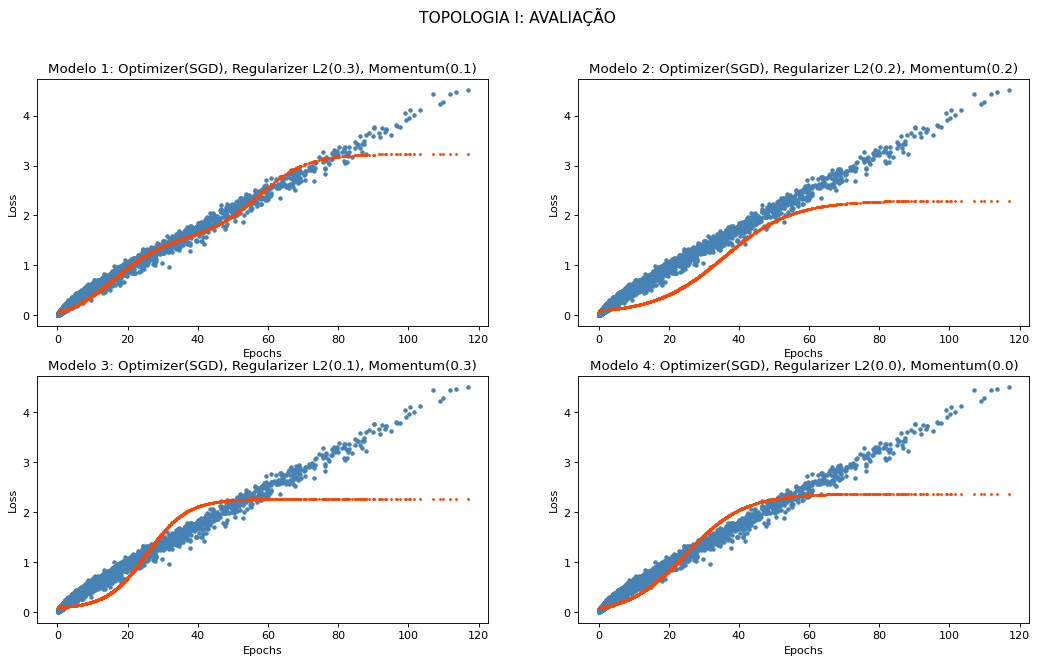

426/426 [==============================] - 1s 2ms/step - loss: 0.0193 - mean_absolute_error: 0.0828


In [248]:
figure(figsize=(16,9),dpi=80)
plt.suptitle('TOPOLOGIA I: AVALIAÇÃO', size=14)
for res in range(0,4):

  plt.subplot(2,2,res+1)
  y_rest = modelos_tpl_I[res].predict(x_test)
  plt.plot(x_test, y_test, '.', color='#4682B4')
  plt.plot(x_test, y_rest, '.', markersize=3 ,color='#FF4500')
  plt.title('Modelo '+ str(res+1) + ': Optimizer(SGD), Regularizer L2('+str(regularizer[res])+'), Momentum('+str(momentum[res])+')')
  plt.xlabel("Epochs")
  plt.ylabel("Loss")

plt.show()


for res in range(0,4):
  test_loss = modelos_tpl_I[res].evaluate(x_test, y_test)

In [242]:
score_modelos_tpl_I = []
for res in range(0,4): 
  score_modelos_tpl_I.append(modelos_tpl_I[res].evaluate(x_test, y_test, verbose=0))
  print('Topologia I - Modelo '+ str(res+1) + ': Optimizer(SGD), Regularizer L2('+str(regularizer[res])+'), Momentum('+str(momentum[res])+')')
  print('Teste loss:',   score_modelos_tpl_I[res][0])
  print('Teste métricas:', score_modelos_tpl_I[res][1])
  print('----------------------------------------')

Topologia I - Modelo 1: Optimizer(SGD), Regularizer L2(0.3), Momentum(0.1)
Teste loss: 0.008290705271065235
Teste métricas: 0.048867326229810715
----------------------------------------
Topologia I - Modelo 2: Optimizer(SGD), Regularizer L2(0.2), Momentum(0.2)
Teste loss: 0.04349048063158989
Teste métricas: 0.1277838796377182
----------------------------------------
Topologia I - Modelo 3: Optimizer(SGD), Regularizer L2(0.1), Momentum(0.3)
Teste loss: 0.0312824472784996
Teste métricas: 0.10957620292901993
----------------------------------------
Topologia I - Modelo 4: Optimizer(SGD), Regularizer L2(0.0), Momentum(0.0)
Teste loss: 0.01930094324052334
Teste métricas: 0.08276467025279999
----------------------------------------




---



## **Topologia II**

A rede neural que será criada será uma MLP com 5 camadas, sendo:
*   01 camada de entrada (input layer) com 10 Neurônios
*   01 camada escondida (hidden layer) com 15 Neurônios
*   01 camada escondida (hidden layer) com 10 Neurônios
*   01 camada escondida (hidden layer) com 5 Neurônios
*   01 camada de saída (output layer) com 1 Neurônio

**Criação do Modelos**

In [213]:
#Modelos da Topologia II
mdl_tpl_II = []

for res in range(0,4):
  #print(i)
  sgd = tf.keras.optimizers.SGD(learning_rate=0.01, momentum=momentum[res])
  mdl_tpl_II.append(keras.Sequential())
  mdl_tpl_II[res].add(keras.layers.Dense(units=10,  kernel_regularizer=l2(regularizer[res]), input_shape=[1], activation="tanh"))
  mdl_tpl_II[res].add(keras.layers.Dense(units=15,  kernel_regularizer=l2(regularizer[res]), activation="tanh"))
  mdl_tpl_II[res].add(keras.layers.Dense(units=10,  kernel_regularizer=l2(regularizer[res]), activation="tanh"))
  mdl_tpl_II[res].add(keras.layers.Dense(units=5,  kernel_regularizer=l2(regularizer[res]), activation="tanh"))
  mdl_tpl_II[res].add(keras.layers.Dense(units=1,  activation="linear"))
  #tf.keras.utils.plot_model(mdl_tpl_II[res], show_shapes=True)
  mdl_tpl_II[res].compile(loss='mean_squared_error', optimizer=sgd, metrics=["mean_absolute_error"])

**Agora vamos treinar os Modelos criados**

In [ ]:
early = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=100)

history_mdl_tpl_II = []
for res in range(0,4):
  history_mdl_tpl_II.append(mdl_tpl_II[res].fit(x_train, y_train, epochs=epochs, batch_size=10, validation_split=0.2, verbose=True)) #callbacks=[early]


**Resultados do Treinamento**

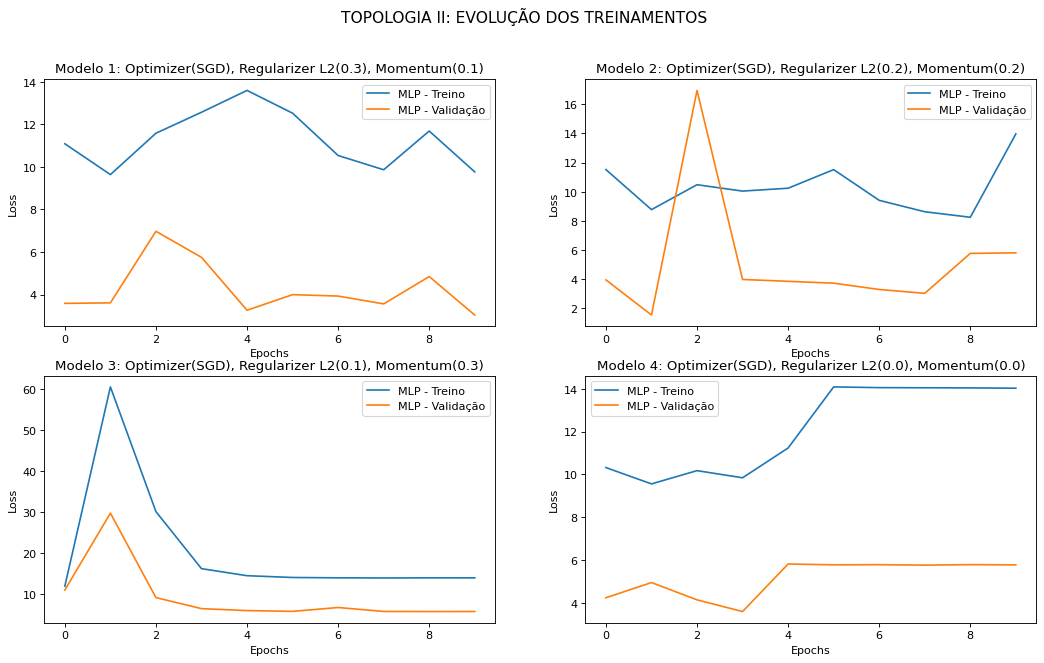

In [249]:
figure(figsize=(16,9),dpi=80)
plt.suptitle('TOPOLOGIA II: EVOLUÇÃO DOS TREINAMENTOS', size=14)
for res in range(0,4):
    plt.subplot(2,2,res+1)
    plt.title('Modelo '+ str(res+1) + ': Optimizer(SGD), Regularizer L2('+str(regularizer[res])+'), Momentum('+str(momentum[res])+')')
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.plot(history_mdl_tpl_II[res].history['loss'], label="MLP - Treino")
    plt.plot(history_mdl_tpl_II[res].history['val_loss'], label="MLP - Validação")
    plt.legend()
plt.show()

**Avaliação**

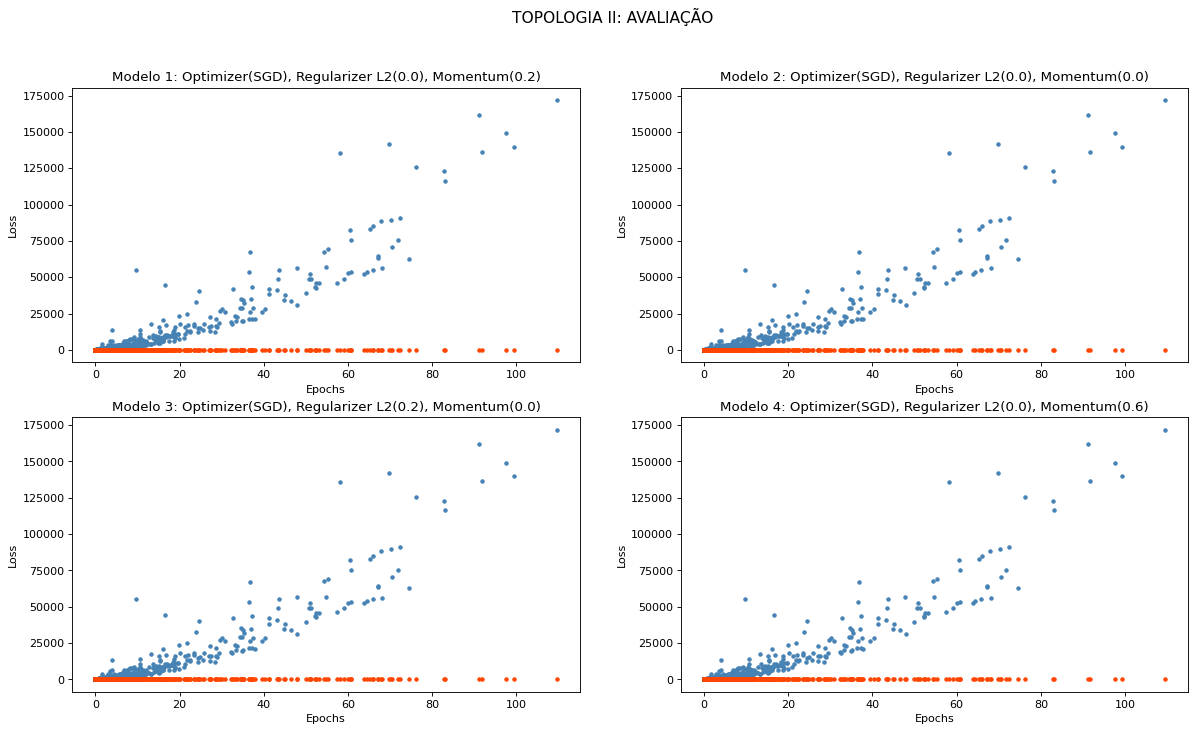

In [195]:
figure(figsize=(16,9),dpi=80)
plt.suptitle('TOPOLOGIA II: AVALIAÇÃO', size=14)

for res in range(0,4):

  plt.subplot(2,2,res+1)
  y_rest = mdl_tpl_II[res].predict(x_train)
  plt.plot(x_train, y_train, '.', color='#4682B4')
  plt.plot(x_train, y_rest, '.',color='#FF4500')
  plt.title('Modelo '+ str(res+1) + ': Optimizer(SGD), Regularizer L2('+str(regularizer[res])+'), Momentum('+str(momentum[res])+')')
  plt.xlabel("Epochs")
  plt.ylabel("Loss")

plt.show()

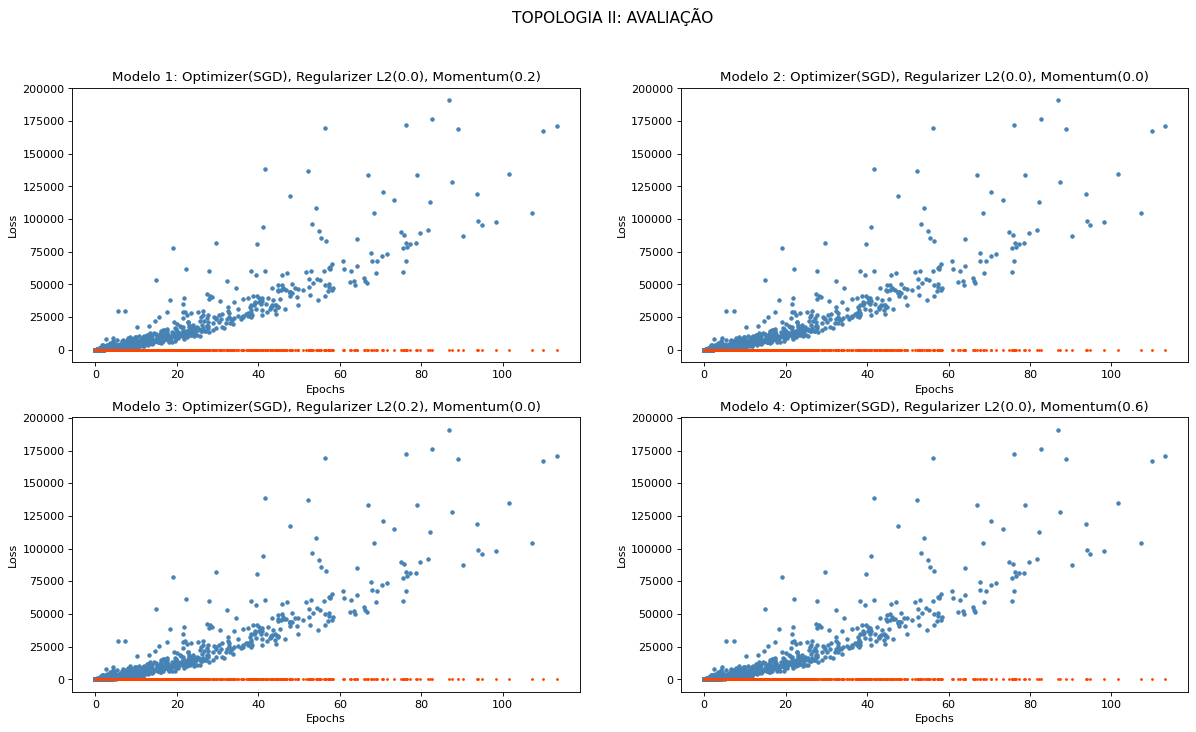

1700/1700 [==============================] - 3s 2ms/step - loss: 16844412.0000 - mean_absolute_error: 281.9701


In [196]:
figure(figsize=(16,9),dpi=80)
plt.suptitle('TOPOLOGIA II: AVALIAÇÃO', size=14)
for res in range(0,4):

  plt.subplot(2,2,res+1)
  y_rest = mdl_tpl_II[res].predict(x_test)
  plt.plot(x_test, y_test, '.', color='#4682B4')
  plt.plot(x_test, y_rest, '.', markersize=3 ,color='#FF4500')
  plt.title('Modelo '+ str(res+1) + ': Optimizer(SGD), Regularizer L2('+str(regularizer[res])+'), Momentum('+str(momentum[res])+')')
  plt.xlabel("Epochs")
  plt.ylabel("Loss")

plt.show()


for res in range(0,4):
  test_loss = mdl_tpl_II[res].evaluate(x_test, y_test)

In [ ]:
score_mdl_tpl_II = []
for res in range(0,4): 
  score_mdl_tpl_II.append(mdl_tpl_II[res].evaluate(x_test, y_test, verbose=0))
  print('Topologia II - Modelo '+ str(res+1) + ': Optimizer(SGD), Regularizer L2('+str(regularizer[res])+'), Momentum('+str(momentum[res])+')')
  print('Teste loss:',   score_mdl_tpl_II[res][0])
  print('Teste métricas:', score_mdl_tpl_II[res][1])
  print('----------------------------------------')



---



## **Topologia III**

A rede neural que será criada será uma MLP com 5 camadas, sendo:
*   01 camada de entrada (input layer) com 15 Neurônios
*   01 camada escondida (hidden layer) com 15 Neurônios
*   01 camada escondida (hidden layer) com 10 Neurônios
*   01 camada escondida (hidden layer) com 5 Neurônios
*   01 camada de saída (output layer) com 1 Neurônio

**Criação do Modelos**

In [ ]:
#Modelos da Topologia III
mdl_tpl_III = []

for res in range(0,4):
  #print(i)
  sgd = tf.keras.optimizers.SGD(learning_rate=0.01, decay=1e-6, momentum=momentum[res])
  mdl_tpl_III.append(keras.Sequential())
  mdl_tpl_III[res].add(keras.layers.Dense(units=15,  kernel_regularizer=l2(regularizer[res]), input_shape=[1], activation="tanh"))
  mdl_tpl_III[res].add(keras.layers.Dense(units=15,  kernel_regularizer=l2(regularizer[res]), activation="tanh"))
  mdl_tpl_III[res].add(keras.layers.Dense(units=10,  kernel_regularizer=l2(regularizer[res]), activation="tanh"))
  mdl_tpl_III[res].add(keras.layers.Dense(units=5,  activation="tanh"))
  mdl_tpl_III[res].add(keras.layers.Dense(units=1,  activation="linear"))
  #tf.keras.utils.plot_model(mdl_tpl_III[res], show_shapes=True)
  mdl_tpl_III[res].compile(loss='mean_squared_error', optimizer=sgd, metrics=["mean_absolute_error"])

**Agora vamos treinar os Modelos criados**

In [ ]:
early = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=100)

history_mdl_tpl_III = []
for res in range(0,4):
  history_mdl_tpl_III.append(mdl_tpl_III[res].fit(x_train, y_train, epochs=epochs, batch_size=10, validation_split=0.2, verbose=True)) #callbacks=[early]


**Resultados do Treinamento**

In [ ]:
figure(figsize=(16,9),dpi=80)
plt.suptitle('TOPOLOGIA III: EVOLUÇÃO DOS TREINAMENTOS', size=14)
for res in range(0,4):
    plt.subplot(2,2,res+1)
    plt.title('Modelo '+ str(res+1) + ': Optimizer(SGD), Regularizer L2('+str(regularizer[res])+'), Momentum('+str(momentum[res])+')')
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.plot(history_mdl_tpl_III[res].history['loss'], label="MLP - Treino")
    plt.plot(history_mdl_tpl_III[res].history['val_loss'], label="MLP - Validação")
    plt.legend()
plt.show()

**Avaliação**

In [ ]:
figure(figsize=(16,9),dpi=80)
plt.suptitle('TOPOLOGIA III: AVALIAÇÃO', size=14)

for res in range(0,4):

  plt.subplot(2,2,res+1)
  y_rest = mdl_tpl_III[res].predict(x_train)
  plt.plot(x_train, y_train, '.', color='#4682B4')
  plt.plot(x_train, y_rest, '.',color='#FF4500')
  plt.title('Modelo '+ str(res+1) + ': Optimizer(SGD), Regularizer L2('+str(regularizer[res])+'), Momentum('+str(momentum[res])+')')
  plt.xlabel("Epochs")
  plt.ylabel("Loss")

plt.show()

In [ ]:
figure(figsize=(16,9),dpi=80)
plt.suptitle('TOPOLOGIA III: AVALIAÇÃO', size=14)
for res in range(0,4):

  plt.subplot(2,2,res+1)
  y_rest = mdl_tpl_III[res].predict(x_test)
  plt.plot(x_test, y_test, '.', color='#4682B4')
  plt.plot(x_test, y_rest, '.', markersize=3 ,color='#FF4500')
  plt.title('Modelo '+ str(res+1) + ': Optimizer(SGD), Regularizer L2('+str(regularizer[res])+'), Momentum('+str(momentum[res])+')')
  plt.xlabel("Epochs")
  plt.ylabel("Loss")

plt.show()


for res in range(0,4):
  test_loss = mdl_tpl_III[res].evaluate(x_test, y_test)

In [ ]:
score_mdl_tpl_III = []
for res in range(0,4): 
  score_mdl_tpl_III.append(mdl_tpl_III[res].evaluate(x_test, y_test, verbose=0))
  print('Topologia III - Modelo '+ str(res+1) + ': Optimizer(SGD), Regularizer L2('+str(regularizer[res])+'), Momentum('+str(momentum[res])+')')
  print('Teste loss:',   score_mdl_tpl_III[res][0])
  print('Teste métricas:', score_mdl_tpl_III[res][1])
  print('----------------------------------------')



---



## **Topologia IV**

A rede neural que será criada será uma MLP com 6 camadas, sendo:
*   01 camada de entrada (input layer) com 20 Neurônios
*   01 camada escondida (hidden layer) com 20 Neurônios
*   01 camada escondida (hidden layer) com 20 Neurônios
*   01 camada escondida (hidden layer) com 10 Neurônios
*   01 camada escondida (hidden layer) com 5 Neurônios
*   01 camada de saída (output layer) com 1 Neurônio

**Criação do Modelos**

In [ ]:
#Modelos da Topologia IV
mdl_tpl_IV = []

for res in range(0,4):
  #print(i)
  sgd = tf.keras.optimizers.SGD(learning_rate=0.01, decay=1e-6, momentum=momentum[res])
  mdl_tpl_IV.append(keras.Sequential())
  mdl_tpl_IV[res].add(keras.layers.Dense(units=20,  kernel_regularizer=l2(regularizer[res]), input_shape=[1], activation="tanh"))
  mdl_tpl_IV[res].add(keras.layers.Dense(units=20,  kernel_regularizer=l2(regularizer[res]), activation="tanh"))
  mdl_tpl_IV[res].add(keras.layers.Dense(units=20,  kernel_regularizer=l2(regularizer[res]), activation="tanh"))
  mdl_tpl_IV[res].add(keras.layers.Dense(units=10,  kernel_regularizer=l2(regularizer[res]), activation="tanh"))
  mdl_tpl_IV[res].add(keras.layers.Dense(units=5,  kernel_regularizer=l2(regularizer[res]), activation="tanh"))
  mdl_tpl_IV[res].add(keras.layers.Dense(units=1, activation="linear"))
  #tf.keras.utils.plot_model(mdl_tpl_IV[res], show_shapes=True)
  mdl_tpl_IV[res].compile(loss='mean_squared_error', optimizer=sgd, metrics=["mean_absolute_error"])

**Agora vamos treinar os Modelos criados**

In [ ]:
early = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=100)

history_mdl_tpl_IV = []
for res in range(0,4):
  history_mdl_tpl_IV.append(mdl_tpl_IV[res].fit(x_train, y_train, epochs=epochs, batch_size=10, validation_split=0.2, verbose=True)) #callbacks=[early]


**Resultados do Treinamento**

In [ ]:
figure(figsize=(16,9),dpi=80)
plt.suptitle('TOPOLOGIA IV: EVOLUÇÃO DOS TREINAMENTOS', size=14)
for res in range(0,4):
    plt.subplot(2,2,res+1)
    plt.title('Modelo '+ str(res+1) + ': Optimizer(SGD), Regularizer L2('+str(regularizer[res])+'), Momentum('+str(momentum[res])+')')
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.plot(history_mdl_tpl_IV[res].history['loss'], label="MLP - Treino")
    plt.plot(history_mdl_tpl_IV[res].history['val_loss'], label="MLP - Validação")
    plt.legend()
plt.show()

**Avaliação**

In [ ]:
figure(figsize=(16,9),dpi=80)
plt.suptitle('TOPOLOGIA IV: AVALIAÇÃO', size=14)

for res in range(0,4):

  plt.subplot(2,2,res+1)
  y_rest = mdl_tpl_IV[res].predict(x_train)
  plt.plot(x_train, y_train, '.', color='#4682B4')
  plt.plot(x_train, y_rest, '.',color='#FF4500')
  plt.title('Modelo '+ str(res+1) + ': Optimizer(SGD), Regularizer L2('+str(regularizer[res])+'), Momentum('+str(momentum[res])+')')
  plt.xlabel("Epochs")
  plt.ylabel("Loss")

plt.show()

In [ ]:
figure(figsize=(16,9),dpi=80)
plt.suptitle('TOPOLOGIA IV: AVALIAÇÃO', size=14)
for res in range(0,4):

  plt.subplot(2,2,res+1)
  y_rest = mdl_tpl_IV[res].predict(x_test)
  plt.plot(x_test, y_test, '.', color='#4682B4')
  plt.plot(x_test, y_rest, '.', markersize=3 ,color='#FF4500')
  plt.title('Modelo '+ str(res+1) + ': Optimizer(SGD), Regularizer L2('+str(regularizer[res])+'), Momentum('+str(momentum[res])+')')
  plt.xlabel("Epochs")
  plt.ylabel("Loss")

plt.show()


for res in range(0,4):
  test_loss = mdl_tpl_IV[res].evaluate(x_test, y_test)

In [ ]:
score_mdl_tpl_IV = []
for res in range(0,4): 
  score_mdl_tpl_IV.append(mdl_tpl_IV[res].evaluate(x_test, y_test, verbose=0))
  print('Topologia III - Modelo '+ str(res+1) + ': Optimizer(SGD), Regularizer L2('+str(regularizer[res])+'), Momentum('+str(momentum[res])+')')
  print('Teste loss:',   score_mdl_tpl_IV[res][0])
  print('Teste métricas:', score_mdl_tpl_IV[res][1])
  print('----------------------------------------')

## **Topologia V**

A rede neural que será criada será uma MLP com 6 camadas, sendo:
*   01 camada de entrada (input layer) com 50 Neurônios
*   01 camada escondida (hidden layer) com 50 Neurônios
*   01 camada escondida (hidden layer) com 50 Neurônios
*   01 camada escondida (hidden layer) com 40 Neurônios
*   01 camada escondida (hidden layer) com 20 Neurônios
*   01 camada de saída (output layer) com 1 Neurônio

**Criação do Modelos**

In [ ]:
#Modelos da Topologia V
mdl_tpl_V = []

for res in range(0,4):
  #print(i)
  sgd = tf.keras.optimizers.SGD(learning_rate=0.01, decay=1e-6, momentum=momentum[res])
  mdl_tpl_V.append(keras.Sequential())
  mdl_tpl_V[res].add(keras.layers.Dense(units=50,  kernel_regularizer=l2(regularizer[res]), input_shape=[1], activation="tanh"))
  mdl_tpl_V[res].add(Dropout(dropout[res]))
  mdl_tpl_V[res].add(keras.layers.Dense(units=50,  kernel_regularizer=l2(regularizer[res]), activation="tanh"))
  mdl_tpl_V[res].add(Dropout(dropout[res]))
  mdl_tpl_V[res].add(keras.layers.Dense(units=50,  kernel_regularizer=l2(regularizer[res]), activation="tanh"))
  mdl_tpl_V[res].add(Dropout(dropout[res]))
  mdl_tpl_V[res].add(keras.layers.Dense(units=40,  kernel_regularizer=l2(regularizer[res]), activation="tanh"))
  mdl_tpl_V[res].add(Dropout(dropout[res]))
  mdl_tpl_V[res].add(keras.layers.Dense(units=20,  kernel_regularizer=l2(regularizer[res]), activation="tanh"))
  mdl_tpl_V[res].add(keras.layers.Dense(units=1, activation="linear"))
  #tf.keras.utils.plot_model(mdl_tpl_V[res], show_shapes=True)
  mdl_tpl_V[res].compile(loss='mean_squared_error', optimizer=sgd, metrics=["mean_absolute_error"])

**Agora vamos treinar os Modelos criados**

In [ ]:
early = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=100)

history_mdl_tpl_V = []
for res in range(0,4):
  history_mdl_tpl_V.append(mdl_tpl_V[res].fit(x_train, y_train, epochs=epochs, batch_size=10, validation_split=0.2, verbose=True)) #callbacks=[early]


**Resultados do Treinamento**

In [ ]:
figure(figsize=(16,9),dpi=80)
plt.suptitle('TOPOLOGIA V: EVOLUÇÃO DOS TREINAMENTOS', size=14)
for res in range(0,4):
    plt.subplot(2,2,res+1)
    plt.title('Modelo '+ str(res+1) + ': Optimizer(SGD), Regularizer L2('+str(regularizer[res])+'), Momentum('+str(momentum[res])+')')
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.plot(history_mdl_tpl_V[res].history['loss'], label="MLP - Treino")
    plt.plot(history_mdl_tpl_V[res].history['val_loss'], label="MLP - Validação")
    plt.legend()
plt.show()

**Avaliação**

In [ ]:
figure(figsize=(16,9),dpi=80)
plt.suptitle('TOPOLOGIA V: AVALIAÇÃO', size=14)

for res in range(0,4):

  plt.subplot(2,2,res+1)
  y_rest = mdl_tpl_V[res].predict(x_train)
  plt.plot(x_train, y_train, '.', color='#4682B4')
  plt.plot(x_train, y_rest, '.',color='#FF4500')
  plt.title('Modelo '+ str(res+1) + ': Optimizer(SGD), Regularizer L2('+str(regularizer[res])+'), Momentum('+str(momentum[res])+')')
  plt.xlabel("Epochs")
  plt.ylabel("Loss")

plt.show()

In [ ]:
figure(figsize=(16,9),dpi=80)
plt.suptitle('TOPOLOGIA V: AVALIAÇÃO', size=14)
for res in range(0,4):

  plt.subplot(2,2,res+1)
  y_rest = mdl_tpl_V[res].predict(x_test)
  plt.plot(x_test, y_test, '.', color='#4682B4')
  plt.plot(x_test, y_rest, '.', markersize=3 ,color='#FF4500')
  plt.title('Modelo '+ str(res+1) + ': Optimizer(SGD), Regularizer L2('+str(regularizer[res])+'), Momentum('+str(momentum[res])+')')
  plt.xlabel("Epochs")
  plt.ylabel("Loss")

plt.show()


for res in range(0,4):
  test_loss = mdl_tpl_V[res].evaluate(x_test, y_test)

In [ ]:
score_mdl_tpl_V = []
for res in range(0,4): 
  score_mdl_tpl_V.append(mdl_tpl_V[res].evaluate(x_test, y_test, verbose=0))
  print('Topologia III - Modelo '+ str(res+1) + ': Optimizer(SGD), Regularizer L2('+str(regularizer[res])+'), Momentum('+str(momentum[res])+')')
  print('Teste loss:',   score_mdl_tpl_V[res][0])
  print('Teste métricas:', score_mdl_tpl_V[res][1])
  print('----------------------------------------')

# **Problema 2: Classificação**

In [ ]:
#Vamos coletar apenas uma parte do Dataset para usá-lo neste Projeto
'''split_date = datetime.datetime(year=2022, month=6,day=1)

df_train_rd80 = df_rd80.loc[df_rd80.index < str(split_date)]
df_val_rd80 = df_rd80.loc[df_rd80.index >= str(split_date)]

df_train_rd80.reset_index(inplace=True)
df_val_rd80.reset_index(inplace=True)

print('Shape do treinamento: ', df_train_rd80.shape)
print('Shape da validação: ', df_val_rd80.shape)
df_train_rd80.head(n=20)'''

In [ ]:
#Visualizando as correlações entre as variáveis
corr = df_rd80.corr()
plt.figure(figsize=(6, 6))
sns.heatmap(corr[(corr >= 0.30) | (corr <= -0.30)],cmap='viridis', vmax=1.0, vmin=-1.0, linewidths=0.1, annot=True, annot_kws={"size": 14}, square=True);